In [1]:
!pip install fastbook
import fastbook

     |████████████████████████████████| 727kB 4.7MB/s 
     |████████████████████████████████| 358kB 12.9MB/s 
     |████████████████████████████████| 1.0MB 22.8MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 40kB 7.2MB/s 
     |████████████████████████████████| 40kB 7.0MB/s 
     |████████████████████████████████| 92kB 11.8MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 2.6MB 35.3MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


# working with the pet dataset

With the real world needs in mind.

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

we need to understand how data is laid out first.

In [3]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

In [4]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('annotations'),Path('images')]

In [5]:
!ls {path}/'annotations'

list.txt  README  test.txt  trainval.txt  trimaps  xmls


In [6]:
!cat {path}/'annotations'/README

OXFORD-IIIT PET Dataset
-----------------------
Omkar M Parkhi, Andrea Vedaldi, Andrew Zisserman and C. V. Jawahar

We have created a 37 category pet dataset with roughly 200 images for each class. 
The images have a large variations in scale, pose and lighting. All images have an 
associated ground truth annotation of breed, head ROI, and pixel
level trimap segmentation.

Contents:
--------
trimaps/ 	Trimap annotations for every image in the dataset
		Pixel Annotations: 1: Foreground 2:Background 3: Not classified
xmls/		Head bounding box annotations in PASCAL VOC Format

list.txt	Combined list of all images in the dataset
		Each entry in the file is of following nature:
		Image CLASS-ID SPECIES BREED ID
		ID: 1:37 Class ids
		SPECIES: 1:Cat 2:Dog
		BREED ID: 1-25:Cat 1:12:Dog
		All images with 1st letter as captial are cat images while
		images with small first letter are dog images.
trainval.txt	Files describing splits used in the paper.However,
test.txt	you are encouraged to try ra

In [7]:
(path/'images').ls()

(#7393) [Path('images/english_setter_33.jpg'),Path('images/american_pit_bull_terrier_53.jpg'),Path('images/Ragdoll_148.jpg'),Path('images/german_shorthaired_132.jpg'),Path('images/shiba_inu_19.jpg'),Path('images/miniature_pinscher_42.jpg'),Path('images/keeshond_124.jpg'),Path('images/boxer_105.jpg'),Path('images/Maine_Coon_2.jpg'),Path('images/Bombay_159.jpg')...]

Most functions and methods in fastai that return a collection use a class called L. L can be thought of as an enhanced version of the ordinary Python list type, with added conveniences for common operations. For instance, when we display an object of this class in a notebook it appears in the format shown there. The first thing that is shown is the number of items in the collection, prefixed with a #. You'll also see in the preceding output that the list is suffixed with an ellipsis. This means that only the first few items are displayed—which is a good thing, because we would not want more than 7,000 filenames on our screen!

In [8]:
fname = (path/'images').ls()[0]

In [9]:
fname

Path('images/english_setter_33.jpg')

The most powerful and flexible way to extract information from strings like this is to use a *regular expression*, also known as a *regex*. A regular expression is a special string, written in the regular expression language, which specifies a general rule for deciding if another string passes a test (i.e., "matches" the regular expression), and also possibly for plucking a particular part or parts out of that other string. 

In this case, we need a regular expression that extracts the pet breed from the filename.

 Let's use the `findall` method to try a regular expression against the filename of the `fname` object:

In [10]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['english_setter']

 fastai comes with many classes to help with labeling. For labeling with regular expressions, we can use the RegexLabeller class. In this example we use the data block API we saw in <> (in fact, we nearly always use the data block API—it's so much more flexible than the simple factory methods we saw in <>):

In [11]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items = get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y= using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms = Resize(460),
                 batch_tfms = aug_transforms(size=224, min_scale=0.75)) 
#item_tfms and batch_tfms implements presizing

dls = pets.dataloaders(path/"images")

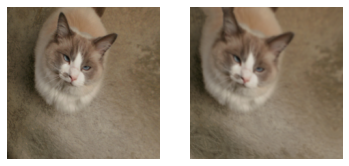

In [12]:
#differnece in fastai and normal approach to image augmentation

dblock1 = DataBlock (blocks=(ImageBlock(), CategoryBlock()),
                      get_y=parent_label,
                     item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(path/'images'/'Ragdoll_191.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_, axs = subplots(1,2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

Checking and debugging a datablock

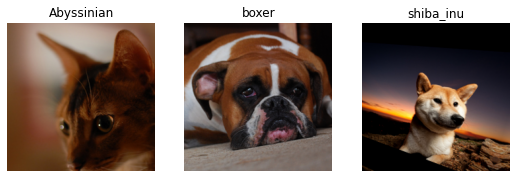

In [13]:
dls.show_batch(nrows=1, ncols=3)

If datablock api fails them datablock.summary will tell you exactly wher it has failed.

In [15]:
# #pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
#                   get_items=get_image_files,
#                   splitter=RandomSplitter(seed=42),
#                   get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name' ))

# #pets1.summary(path/"images")

In [16]:
# trying the data on a simple model

learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.642420,0.408480,0.125846,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.572996,0.320934,0.097429,01:09
1,0.387696,0.270676,0.080514,01:08


Remember that loss is whatever function we've decided to use to optimize the parameters of our model. But we haven't actually told fastai what loss function we want to use. So what is it doing? fastai will generally try to select an appropriate loss function based on what kind of data and model you are using. In this case we have image data and a categorical outcome, so fastai will default to using cross-entropy loss.

### Cross entropy loss

Cross-entropy loss is a loss function that is similar to the one we used in the previous chapter, but (as we'll see) has two benefits:

It works even when our dependent variable has more than two categories.
It results in faster and more reliable training.
In order to understand how cross-entropy loss works for dependent variables with more than two categories, we first have to understand what the actual data and activations that are seen by the loss function look like.

In [17]:
x,y = dls.one_batch()

Our batch size is 64, so we have 64 rows in this tensor. Each row is a single integer between 0 and 36, representing our 37 possible pet breeds. We can view the predictions (that is, the activations of the final layer of our neural network) using `Learner.get_preds`. This function either takes a dataset index (0 for train and 1 for valid) or an iterator of batches. Thus, we can pass it a simple list with our batch to get our predictions. It returns predictions and targets by default, but since we already have the targets, we can effectively ignore them by assigning to the special variable `_`:

In [18]:
y

TensorCategory([36, 11, 10,  8,  7, 13, 27, 32, 13, 29,  9,  0, 20, 25,  6,  5,  2, 24, 10,  7, 10,  7,  4,  8,  4, 15,  5, 16, 36, 31, 21, 27, 26, 29,  7,  6, 28, 35, 29, 26, 17,  7, 24, 22,  1, 13, 29, 31,
         8, 19, 33, 28, 20,  5,  7,  8, 36, 34,  1, 29,  1, 28, 31, 21], device='cuda:0')

In [23]:
x[0]

tensor([[[-1.2180, -1.1666, -1.1145,  ..., -1.6444, -1.6332, -1.6541],
         [-1.1634, -1.1965, -1.1158,  ..., -1.6008, -1.5891, -1.6157],
         [-1.1118, -1.1797, -1.1089,  ..., -1.6028, -1.6025, -1.6349],
         ...,
         [ 1.0836,  1.0732,  1.0483,  ...,  1.1404,  1.1080,  1.1458],
         [ 1.0786,  1.0001,  1.0241,  ...,  1.0302,  0.9941,  1.1705],
         [ 0.9981,  0.9635,  0.9663,  ...,  1.0416,  1.0932,  1.1433]],

        [[-0.5941, -0.5135, -0.4265,  ..., -1.5322, -1.5139, -1.5227],
         [-0.5429, -0.5579, -0.4735,  ..., -1.5062, -1.4945, -1.5190],
         [-0.5007, -0.5646, -0.5196,  ..., -1.5091, -1.5088, -1.5419],
         ...,
         [ 1.1952,  1.1901,  1.1478,  ...,  0.7720,  0.6832,  0.7153],
         [ 1.1629,  1.0912,  1.1102,  ...,  0.6960,  0.6276,  0.7656],
         [ 1.0581,  1.0324,  1.0338,  ...,  0.7310,  0.7566,  0.7569]],

        [[-0.9404, -0.9294, -0.8869,  ..., -1.2495, -1.2192, -1.2945],
         [-0.8526, -0.9406, -0.8952,  ..., -1

In [20]:
preds, unknown = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.0810e-04, 1.9254e-04, 4.7978e-05, 6.3297e-06, 1.4183e-05, 9.1703e-05, 6.5365e-04, 1.8965e-03, 4.7546e-05, 5.1381e-07, 8.9175e-06, 5.6981e-04, 1.9966e-05, 1.6210e-05, 1.4773e-05, 2.7045e-05,
        6.4951e-05, 3.7548e-05, 2.1692e-04, 1.2992e-04, 2.1857e-05, 2.7373e-05, 2.9260e-02, 1.0678e-03, 1.5556e-06, 1.4317e-05, 2.1588e-04, 8.2753e-06, 6.0074e-04, 1.0063e-05, 2.4599e-06, 3.0321e-05,
        5.4692e-04, 2.0499e-05, 3.4926e-06, 3.3490e-04, 9.6367e-01])

In [21]:
unknown

TensorCategory([36, 11, 10,  8,  7, 13, 27, 32, 13, 29,  9,  0, 20, 25,  6,  5,  2, 24, 10,  7, 10,  7,  4,  8,  4, 15,  5, 16, 36, 31, 21, 27, 26, 29,  7,  6, 28, 35, 29, 26, 17,  7, 24, 22,  1, 13, 29, 31,
         8, 19, 33, 28, 20,  5,  7,  8, 36, 34,  1, 29,  1, 28, 31, 21])

In [22]:
len(preds[0]), preds[0].sum()
#The actual predictions are 37 probabilities between 0 and 1, which add up to 1 in total:



(37, tensor(1.))

We will use softmax to ensure that all activations are all between 0 and 1 and that their sum is equal to one

In [24]:
#plot_function(torch.sigmoid, min=-4, max=4)

NameError: ignored

We can apply this function to a single column of activations from a neural network, and get back a column of numbers between 0 and 1, so it's a very useful activation function for our final layer.

Now think about what happens if we want to have more categories in our target (such as our 37 pet breeds). That means we'll need more activations than just a single column: we need an activation *per category*. We can create, for instance, a neural net that predicts 3s and 7s that returns two activations, one for each class—this will be a good first step toward creating the more general approach. Let's just use some random numbers with a standard deviation of 2 (so we multiply `randn` by 2) for this example, assuming we have 6 images and 2 possible categories (where the first column represents 3s and the second is 7s)

In [28]:
from fastbook import *

torch.random.manual_seed(42)
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

We can't just take the sigmoid of this directly, since we don't get rows that add to 1 (i.e., we want the probability of being a 3 plus the probability of bein

In [29]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [30]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

The second column (the probability of it being a 7) will then just be that value subtracted from 1. Now, we need a way to do all this that also works for more than two columns. It turns out that this function, called `softmax`, is exactly that:

``` python
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
```

In [31]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

`softmax` is the multi-category equivalent of `sigmoid`—we have to use it any time we have more than two categories and the probabilities of the categories must add to 1, and we often use it even when there are just two categories, just to make things a bit more consistent. We could create other functions that have the properties that all activations are between 0 and 1, and sum to 1; however, no other function has the same relationship to the sigmoid function, which we've seen is smooth and symmetric. Also, we'll see shortly that the softmax function works well hand-in-hand with the loss function we will look at in the next section.

If we have three output activations, such as in our bear classifier, calculating softmax for a single bear image would then look like something like <<bear_softmax>>.

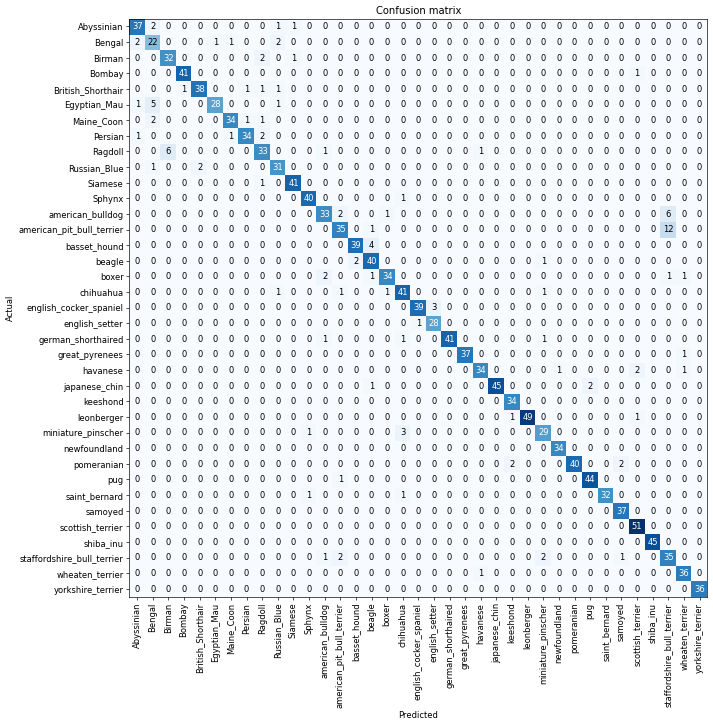

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [33]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 12),
 ('Ragdoll', 'Birman', 6),
 ('american_bulldog', 'staffordshire_bull_terrier', 6),
 ('Egyptian_Mau', 'Bengal', 5)]

In [34]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.993562,3.618595,0.439783,01:10


epoch,train_loss,valid_loss,error_rate,time
0,3.712915,10.489351,0.622463,01:14


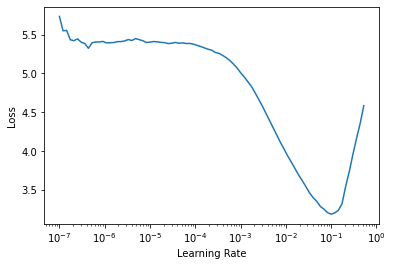

In [35]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()bb

In [36]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 6.31e-03


In [37]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.329461,0.297113,0.089986,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.528076,0.367718,0.110961,01:15
1,0.339706,0.238971,0.070365,01:15


In [38]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.133491,0.352977,0.118403,01:10
1,0.514001,0.258058,0.074425,01:09
2,0.318685,0.229152,0.070365,01:09


In [39]:
learn.unfreeze()

SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=9.12010818865383e-07)

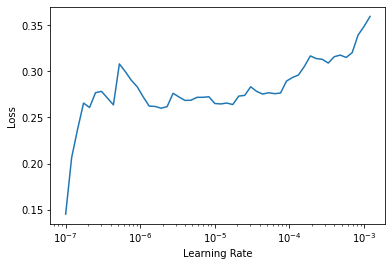

In [40]:
learn.lr_find()

Note that the graph is a little different from when we had random weights: we don't have that sharp descent that indicates the model is training. That's because our model has been trained already. Here we have a somewhat flat area before a sharp increase, and we should take a point well before that sharp increase—for instance, 1e-5. The point with the maximum gradient isn't what we look for here and should be ignored.

In [41]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.253809,0.216660,0.068336,01:15
1,0.243643,0.210378,0.066306,01:15
2,0.223095,0.206647,0.066306,01:16
3,0.198697,0.200884,0.066306,01:16
4,0.196063,0.197582,0.062246,01:16
5,0.189752,0.197813,0.064276,01:16


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

# it shows disxriminative learning rate

epoch,train_loss,valid_loss,error_rate,time
0,1.132126,0.358507,0.119080,01:11
1,0.529341,0.253824,0.077808,01:10
2,0.318365,0.226408,0.071719,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.260203,0.222583,0.066982,01:15
1,0.238983,0.218045,0.064276,01:14
2,0.207011,0.209659,0.063599,01:14


In [ ]:
learn.recorder.plot_loss()

In [ ]:
# from fastai.callback.fp16 import *
# learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
# learn.fine_tune(6, freeze_epochs=3)